# Initialization

In [1]:
!pip install boto3 astropy sfdmap progressbar2 GPUtil parse

In [2]:
# imports
import pandas as pd
import numpy as np
import os
import sys
import pickle
import boto3
from matplotlib import pyplot as plt
import time

# random seed
seed = 42
np.random.seed(seed)

# local files paths
local_home_dir_path = os.path.expanduser("~")
local_work_dir_path = os.path.join(local_home_dir_path, 'thesis2')
local_code_dir_path = os.path.join(local_work_dir_path , 'code')

# S3 file paths
endpoint_url = 'https://s3-west.nrp-nautilus.io'
bucket_name = 'tau-astro'
prefix = 'almogh'
s3_work_dir_path = os.path.join(prefix, 'thesis2')
s3_data_dir_path = os.path.join(s3_work_dir_path , 'data')
s3_models_dir_path = os.path.join(s3_work_dir_path , 'models')
s3_final_table_csv_path = os.path.join(s3_data_dir_path, 'SDSS_DR16_all.csv')

s3_client = boto3.client("s3", endpoint_url=endpoint_url)

# adding code folder to path
sys.path.insert(1, local_code_dir_path)
from s3 import to_s3_npy, to_s3_pkl, from_s3_npy, from_s3_pkl, to_s3_fig

# Load Data

In [3]:
gs = from_s3_pkl(s3_client = s3_client, bucket_name = bucket_name,
    path_in_bucket = 'almogh/thesis2/data/BigRF/train/gs.pkl')

loading from uri: s3://tau-astro/almogh/thesis2/data/BigRF/train/gs.pkl


In [4]:
galSpecExtra = from_s3_pkl(s3_client = s3_client, bucket_name = bucket_name,
    path_in_bucket = 'almogh/thesis2/data/galSpecExtra.pkl')

loading from uri: s3://tau-astro/almogh/thesis2/data/galSpecExtra.pkl


In [5]:
galSpecLine = from_s3_pkl(s3_client = s3_client, bucket_name = bucket_name,
    path_in_bucket = 'almogh/thesis2/data/galSpecLine.pkl')

loading from uri: s3://tau-astro/almogh/thesis2/data/galSpecLine.pkl


In [6]:
gs['specObjID'] = gs['specobjid'].astype(np.int64)
gs = gs.merge(galSpecLine, on='specObjID')
gs = gs.merge(galSpecExtra, on='specObjID')

In [7]:
for col in gs.columns:
    print(col)

specobjid
snMedian
run2d
ra
dec
plate
mjd
fiberid
waveMin
waveMax
z
weirdness
spectrotype
subclass
oii_3726_eqw
oii_3729_eqw
neiii_3869_eqw
h_delta_eqw
h_gamma_eqw
oiii_4363_eqw
h_beta_eqw
oiii_4959_eqw
oiii_5007_eqw
hei_5876_eqw
oi_6300_eqw
nii_6548_eqw
h_alpha_eqw
nii_6584_eqw
sii_6717_eqw
sii_6731_eqw
ariii7135_eqw
waveMin_rest
waveMax_rest
specObjID
h_alpha_flux
h_beta_flux
oiii_5007_flux
nii_6584_flux
sii_6717_flux
oi_6300_flux
bptclass
oh_p50
lgm_tot_p50
sfr_tot_p50
specsfr_tot_p50


# Plot

In [15]:
# Imports
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D  # for legend handle

In [9]:
gs['oiii_5007_flux_/_h_beta_flux'] = gs['oiii_5007_flux']/gs['h_beta_flux'] # y-axis of the BPT diagrams
gs['nii_6584_flux_/h_alpha_flux'] = gs['nii_6584_flux']/gs['h_alpha_flux'] # x-axis of the 1st BPT diagram
gs['sii_6717_flux_/h_alpha_flux'] = gs['sii_6717_flux']/gs['h_alpha_flux'] # x-axis of the 2nd BPT diagram
gs['oi_6300_flux_/h_alpha_flux'] = gs['oi_6300_flux']/gs['h_alpha_flux'] # x-axis of the 3rd BPT diagram

In [20]:
bptclasses = {-1:'unclassifiable', 1:'star-forming', 2:'low S/N star-forming', 3:'composite', 4:'AGN (excluding LINERS)', 5:'low S/N LINERS'}
gs['bptclass'] = gs['bptclass'].map(bptclasses)
colors_num = {-1:'tab:blue', 1:'tab:orange', 2:'tab:green', 3:'tab:red', 4:'tab:purple', 5:'tab:brown'}
colors_class = {v:colors_num[k] for k,v in bptclasses.items()}

In [25]:
gs['bptclass'].map(colors_class).unique()

array(['tab:orange', 'tab:blue', 'tab:brown', 'tab:green', 'tab:red',
       'tab:purple'], dtype=object)

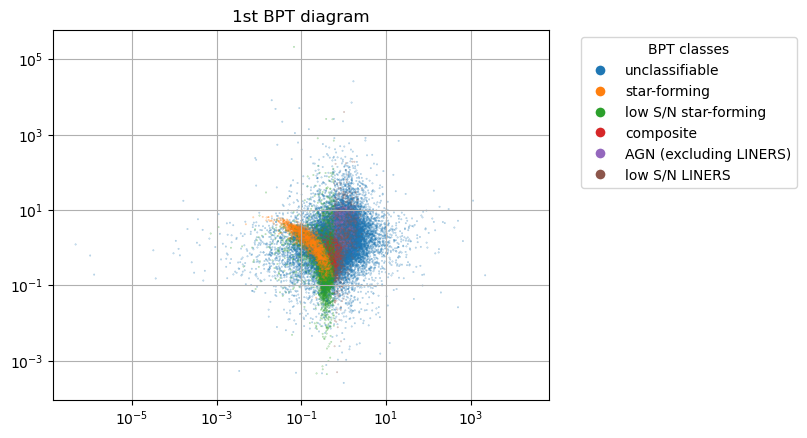

In [27]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(gs['nii_6584_flux_/h_alpha_flux'] ,gs['oiii_5007_flux_/_h_beta_flux'] , s=0.1, c=gs['bptclass'].map(colors_class), alpha=0.5)
ax.set_yscale('log')
ax.set_xscale('log')
ax.grid(which='both')
ax.set_title('1st BPT diagram')

handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors_class.items()]
ax.legend(title='BPT classes', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

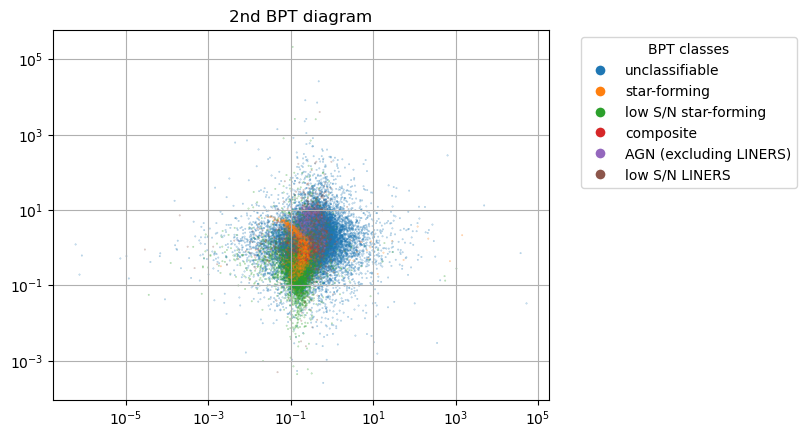

In [31]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(gs['sii_6717_flux_/h_alpha_flux'] ,gs['oiii_5007_flux_/_h_beta_flux'] , s=0.1, c=gs['bptclass'].map(colors_class), alpha=0.5)
ax.set_yscale('log')
ax.set_xscale('log')
ax.grid(which='both')
ax.set_title('2nd BPT diagram')

handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors_class.items()]
ax.legend(title='BPT classes', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

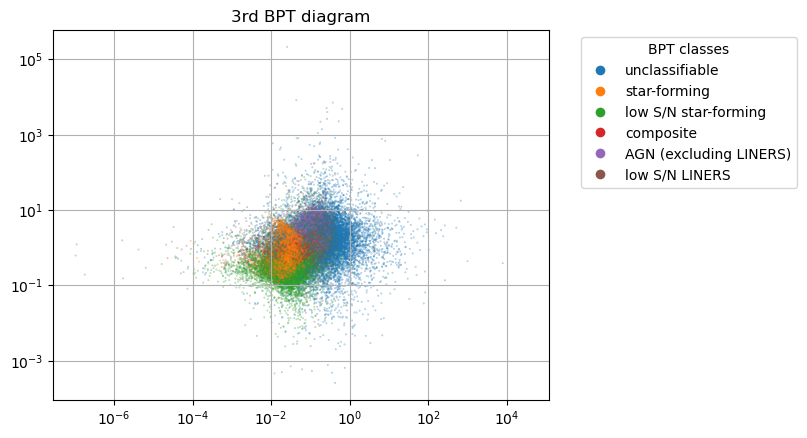

In [30]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(gs['oi_6300_flux_/h_alpha_flux'] ,gs['oiii_5007_flux_/_h_beta_flux'] , s=0.1, c=gs['bptclass'].map(colors_class), alpha=0.5)
ax.set_yscale('log')
ax.set_xscale('log')
ax.grid(which='both')
ax.set_title('3rd BPT diagram')

handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors_class.items()]
ax.legend(title='BPT classes', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()